<Figure size 432x288 with 0 Axes>

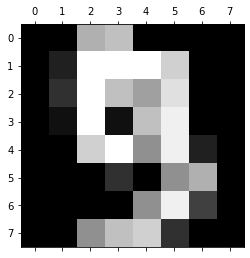

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
digits = load_digits()
data = digits.data
targets = digits.target
norm_data = normalize(data, axis=0)
plt.gray()
plt.matshow(digits.images[9])
plt.show()

In [19]:
digits.images.shape

(1797, 8, 8)

In [2]:
train_data, test_data, train_targets, test_targets = train_test_split(norm_data, targets, train_size=0.8)

In [77]:
train_data.shape

(1437, 64)

In [3]:
#train targets converted to one-hot format for loss calculation
train_targets_1hot = np.zeros((train_targets.shape[0], 10))
for index, value in enumerate(train_targets):
    train_targets_1hot[index, value] = 1
#test targets converted to one-hot format for loss calculation
test_targets_1hot = np.zeros((test_targets.shape[0], 10))
for index, value in enumerate(test_targets):
    test_targets_1hot[index, value] = 1

In [24]:
train_targets_1hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [4]:
import numpy as np

def tanh(g):
    return np.tanh(g)

In [5]:
def gradClip(data):
    clipped_data = np.clip(data, a_min = -1, a_max = 1)
    return clipped_data

In [6]:
def softmax(z):
    e_x = np.exp(z)
    sm = e_x / e_x.sum(axis=0)
    return sm

In [7]:
def compute(weight, input, bias):
    a = np.dot(weight, input) + bias
    return a

In [8]:
def averageCE(y_target, y_pred):
  N =y_target.shape[0]
  CE = np.sum(y_target * np.log(y_pred.T)) # Softmax Loss
  avg_ce = (-1 / N ) * CE 
  return avg_ce

In [9]:
def gradCE(y_target, y_pred):
  N =y_target.shape[0]
  dy_pred = ( 1 / N ) * (y_pred.T - y_target)    # dL/dY for softmax
  return dy_pred

In [139]:
def params(data, targets, hidden_size = 1000):
    # Define hyperparameters
    # hidden_size = 1000

# train_data = (1437 X 64)
    input_size = data.shape[1]
    output_size = len(np.unique(targets))


# Initializing Weights and biases according to Xaviers's initialization scheme
    np.random.seed(1)
    wh = np.random.normal(0, 1, (hidden_size, input_size)) #hidden layer weights
    bh = np.zeros((hidden_size,1)) #hidden layer bias
    wo = np.random.normal(0, 1, (hidden_size, output_size)) #output layer weights
    bo = np.zeros((output_size, 1)) #output layer bias

# Initializing the momentum matrices to e^-5
    v_wh = np.exp(-5 * np.ones((wh.shape)))
    v_bh = np.exp(-5 * np.ones((bh.shape)))
    v_wo = np.exp(-5 * np.ones((wo.shape)))
    v_bo = np.exp(-5 * np.ones((bo.shape)))
    return wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo

In [126]:
print(" shape of wh " +  str(wh.shape))
print(" shape of train_data " +  str(train_data.shape))
print(" shape of bh " +  str(bh.shape))
print(" shape of wo " +  str(wo.shape))
print(" shape of bo " +  str(bo.shape))
print(" shape of train_targets " +  str(train_targets_1hot.shape))
# print(train_targets_1hot)

 shape of wh (1000, 64)
 shape of train_data (1437, 64)
 shape of bh (1000, 1)
 shape of wo (1000, 10)
 shape of bo (10, 1)
 shape of train_targets (1437, 10)


In [12]:
# FORWARD PROPAGATION
def forward_prop(data, wh, bh, wo, bo, targets):
  g = compute(wh, data.T, bh)
  # print(" shape of g " +  str(g.shape))
  h = tanh(g)
  # print(" shape of h " +  str(h.shape))
  z = compute(wo.T, h, bo)
  # print(" shape of z " +  str(z.shape))
  y = softmax(z)
  # print(" shape of y " +  str(y.shape))
  # print(y)
  l = averageCE(targets, y)
  return g, h, z, y, l

In [68]:
# BACKPROPAGATION
def backprop_grads(g, h, z, y, l, data, targets):
  N =data.shape[0]
  dl = 1
  # print("dl = ", dl.shape)
  dy = gradCE(targets, y)
  # print("dy = ", dy.shape)
  dz = dy
  # print("dz =  ", dz.shape)
  dwo = np.dot(dz.T, h.T)
  # print("dwo = ", dwo.shape)
  dbo = np.dot(dz.T, np.ones((N,1)))
  # print("dbo =  ", dbo.shape)
  dh = np.dot(dz, wo.T)
  # print("dh = ", dh.shape)
  dg = dh * (1 - (tanh(g) * tanh(g))).T
  # print("dg = ", dg.shape)
  dwh = np.dot(dg.T, data)
  # print("dwh = ", dwh.shape)
  dbh = np.dot(dg.T, np.ones((N,1)))
  # print("dbh = ", dbh.shape)
  return dwo, dbo, dwh, dbh

In [137]:
def predict(num_epochs, data, wh, bh, wo, bo, targets, v_wo, v_bo, v_wh, v_bh, target_acc, alpha, gamma ):
  # alpha = 0.001 # learning rate
  # gamma = 0.9 # momentum
  losses = []
  acc = []
  for i in range(num_epochs):
    g, h, z, y, l = forward_prop(data, wh, bh, wo, bo, targets)
    dwo, dbo, dwh, dbh = backprop_grads(g, h, z, y, l, data, targets)
    v_wo = (gamma * v_wo ) + (alpha * gradClip(dwo.T))
    v_bo = (gamma * v_bo ) + (alpha * gradClip(dbo))
    v_wh = (gamma * v_wh ) + (alpha * gradClip(dwh))
    v_bh = (gamma * v_bh ) + (alpha * gradClip(dbh))
    wo = wo - v_wo
    bo = bo - v_bo
    wh = wh - v_bh
    bh = bh - v_bh
    if i % 2500 == 0 :
      print("Epoch = ", i , " loss = ", l)
    pred_labels = np.argmax(y, axis=0)
    # Calculate the accuracy
    accuracy = np.mean(pred_labels == target_acc) * 100
    acc.append(accuracy)
    losses.append(l)
  return losses, y, wh, bh, wo, bo, acc

In [140]:
#  TRAINING
num_epochs = 50000
wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo = params(train_data, train_targets, hidden_size = 1000)
train_losses, y_tr, wh, bh, wo, bo, train_acc = predict(num_epochs, train_data, wh, bh, wo, bo, train_targets_1hot, v_wo, v_bo, v_wh, v_bh, train_targets, alpha = 0.001, gamma = 0.9)

Epoch =  0  loss =  7.87842667613595
Epoch =  2500  loss =  0.6427253788560989
Epoch =  5000  loss =  0.38127759435081127
Epoch =  7500  loss =  0.2846976466980507
Epoch =  10000  loss =  0.23336003568524463
Epoch =  12500  loss =  0.2009188724760767
Epoch =  15000  loss =  0.1783107761217285
Epoch =  17500  loss =  0.16149586626566426
Epoch =  20000  loss =  0.1484066997951333
Epoch =  22500  loss =  0.13787077006473616
Epoch =  25000  loss =  0.12916887763158938
Epoch =  27500  loss =  0.12183299678155199
Epoch =  30000  loss =  0.11554442147672045
Epoch =  32500  loss =  0.11007814580989486
Epoch =  35000  loss =  0.10527050950486688
Epoch =  37500  loss =  0.10099942498784943
Epoch =  40000  loss =  0.09717181866180859
Epoch =  42500  loss =  0.09371540060151147
Epoch =  45000  loss =  0.09057311953819373
Epoch =  47500  loss =  0.08769932818985093


In [ ]:
wh_trained, bh_trained, wo_trained, bo_trained = wh, bh, wo, bo

In [141]:
# TESTING DATA
num_epochs = 50000
wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo = params(test_data, test_targets, hidden_size = 1000)
test_losses, y_tst, wh, bh, wo, bo, test_acc = predict(num_epochs, test_data, wh, bh, wo, bo, test_targets_1hot, v_wo, v_bo, v_wh, v_bh, test_targets, alpha = 0.001, gamma = 0.9)

Epoch =  0  loss =  7.851003619480124
Epoch =  2500  loss =  0.5863972430857074
Epoch =  5000  loss =  0.3028185480905086
Epoch =  7500  loss =  0.20981537469960315
Epoch =  10000  loss =  0.16296949016864481
Epoch =  12500  loss =  0.1343453452598353
Epoch =  15000  loss =  0.1146883559010388
Epoch =  17500  loss =  0.10019203328483087
Epoch =  20000  loss =  0.08901256345605418
Epoch =  22500  loss =  0.08012017515057814
Epoch =  25000  loss =  0.07287964419697092
Epoch =  27500  loss =  0.06687295467261495
Epoch =  30000  loss =  0.06181224469483886
Epoch =  32500  loss =  0.05749229303089834
Epoch =  35000  loss =  0.05376271889031449
Epoch =  37500  loss =  0.05051083744204503
Epoch =  40000  loss =  0.04765061617534335
Epoch =  42500  loss =  0.04511530270211713
Epoch =  45000  loss =  0.042852361037174755
Epoch =  47500  loss =  0.04081991302250861


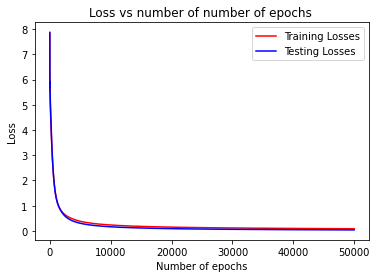

In [142]:
import matplotlib.pyplot as plt

# LOSSES
plt.plot(range(num_epochs), train_losses, color = 'red', label= 'Training Losses')
plt.plot(range(num_epochs), test_losses, color = 'blue', label= 'Testing Losses')
plt.title("Loss vs number of number of epochs ")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

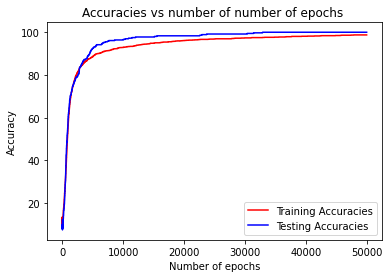

In [143]:
import matplotlib.pyplot as plt

# ACCURACIES
plt.plot(range(num_epochs), train_acc, color = 'red', label= 'Training Accuracies')
plt.plot(range(num_epochs), test_acc, color = 'blue', label= 'Testing Accuracies')
plt.title("Accuracies vs number of number of epochs ")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [144]:
num_epochs = 50000
# Unit size = 100
print("unit size", 100)
wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo = params(test_data, test_targets, hidden_size = 100)
test_losses, y_tst, wh, bh, wo, bo, test_acc_100 = predict(num_epochs, test_data, wh, bh, wo, bo, test_targets_1hot, v_wo, v_bo, v_wh, v_bh, test_targets, alpha = 0.001, gamma = 0.9)
    

unit size 100
Epoch =  0  loss =  3.314745524943104
Epoch =  2500  loss =  1.647599002425352
Epoch =  5000  loss =  1.2773996104855134
Epoch =  7500  loss =  1.1047883855503478
Epoch =  10000  loss =  0.9979697999439417
Epoch =  12500  loss =  0.9210200861751339
Epoch =  15000  loss =  0.8617416265762318
Epoch =  17500  loss =  0.8137930639666591
Epoch =  20000  loss =  0.7734032627593188
Epoch =  22500  loss =  0.7384406555328041
Epoch =  25000  loss =  0.7076611034471273
Epoch =  27500  loss =  0.6802792125875132
Epoch =  30000  loss =  0.6557691701013214
Epoch =  32500  loss =  0.633756712018369
Epoch =  35000  loss =  0.6139099671449312
Epoch =  37500  loss =  0.5958777894235842
Epoch =  40000  loss =  0.5793528459844614
Epoch =  42500  loss =  0.5641291422304808
Epoch =  45000  loss =  0.5500758410219722
Epoch =  47500  loss =  0.5370905330746022


In [145]:
num_epochs = 50000
# Unit size = 500
print("unit size", 500)
wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo = params(test_data, test_targets, hidden_size = 500)
test_losses, y_tst, wh, bh, wo, bo, test_acc_500 = predict(num_epochs, test_data, wh, bh, wo, bo, test_targets_1hot, v_wo, v_bo, v_wh, v_bh, test_targets, alpha = 0.001, gamma = 0.9)

unit size 500
Epoch =  0  loss =  4.864617909597928
Epoch =  2500  loss =  0.9811307101490144
Epoch =  5000  loss =  0.5386123832706965
Epoch =  7500  loss =  0.3787506789548635
Epoch =  10000  loss =  0.2973644226620388
Epoch =  12500  loss =  0.24946221431813284
Epoch =  15000  loss =  0.2174201621454251
Epoch =  17500  loss =  0.19426184972453558
Epoch =  20000  loss =  0.1765939502209069
Epoch =  22500  loss =  0.16255806828668903
Epoch =  25000  loss =  0.15105919305230237
Epoch =  27500  loss =  0.14141268080839453
Epoch =  30000  loss =  0.13316797061264798
Epoch =  32500  loss =  0.12601539918068103
Epoch =  35000  loss =  0.11973426333864252
Epoch =  37500  loss =  0.11416238064870016
Epoch =  40000  loss =  0.10917743191098235
Epoch =  42500  loss =  0.10468507648952242
Epoch =  45000  loss =  0.10061112946092084
Epoch =  47500  loss =  0.09689626447671344


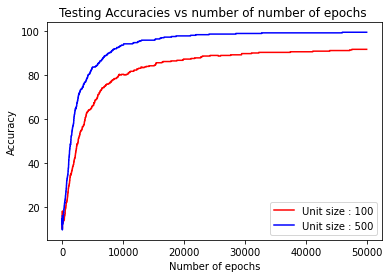

In [148]:
import matplotlib.pyplot as plt

# ACCURACIES
plt.plot(range(num_epochs), test_acc_100, color = 'red', label= 'Unit size : 100')
plt.plot(range(num_epochs), test_acc_500, color = 'blue', label= 'Unit size : 500')
plt.title("Testing Accuracies vs number of number of epochs ")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

In [150]:
#  TRAINING

# Learning rate =  0.01
num_epochs = 50000
wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo = params(train_data, train_targets, hidden_size = 1000)
train_losses_lr001, y_tr, wh, bh, wo, bo, train_acc = predict(num_epochs, train_data, wh, bh, wo, bo, train_targets_1hot, v_wo, v_bo, v_wh, v_bh, train_targets, alpha = 0.01, gamma = 0.9)

Epoch =  0  loss =  7.87842667613595
Epoch =  2500  loss =  0.1288974112892645
Epoch =  5000  loss =  0.08478135872849862
Epoch =  7500  loss =  0.0664540897572393
Epoch =  10000  loss =  0.05562397819455919
Epoch =  12500  loss =  0.04829288574047641
Epoch =  15000  loss =  0.04295244505304985
Epoch =  17500  loss =  0.038865071611672894
Epoch =  20000  loss =  0.03562228789435303
Epoch =  22500  loss =  0.03297833619781114
Epoch =  25000  loss =  0.030775459792156037
Epoch =  27500  loss =  0.0289073291267812
Epoch =  30000  loss =  0.0272995667934631
Epoch =  32500  loss =  0.025898544211854738
Epoch =  35000  loss =  0.024664585347351557
Epoch =  37500  loss =  0.023567686222987386
Epoch =  40000  loss =  0.02258472732610066
Epoch =  42500  loss =  0.021697601749544642
Epoch =  45000  loss =  0.02089192459139311
Epoch =  47500  loss =  0.020156123106142156


In [151]:
#  TRAINING

# Learning rate =  0.0001
num_epochs = 50000
wh, bh, wo, bo, v_wh, v_bh, v_wo, v_bo = params(train_data, train_targets, hidden_size = 1000)
train_losses_lr0001, y_tr, wh, bh, wo, bo, train_acc = predict(num_epochs, train_data, wh, bh, wo, bo, train_targets_1hot, v_wo, v_bo, v_wh, v_bh, train_targets, alpha = 0.0001, gamma = 0.9)

Epoch =  0  loss =  7.87842667613595
Epoch =  2500  loss =  3.795889750921914
Epoch =  5000  loss =  2.5522987814117166
Epoch =  7500  loss =  1.7973610935197177
Epoch =  10000  loss =  1.3650855029107825
Epoch =  12500  loss =  1.1103523245996996
Epoch =  15000  loss =  0.9503739651723925
Epoch =  17500  loss =  0.8400342474331515
Epoch =  20000  loss =  0.7580056045995026
Epoch =  22500  loss =  0.6938403366844008
Epoch =  25000  loss =  0.6417828324779106
Epoch =  27500  loss =  0.5983630091857685
Epoch =  30000  loss =  0.5613484249164248
Epoch =  32500  loss =  0.5292325347991886
Epoch =  35000  loss =  0.5009606486230245
Epoch =  37500  loss =  0.4757720313628426
Epoch =  40000  loss =  0.45310407365243155
Epoch =  42500  loss =  0.432532781263284
Epoch =  45000  loss =  0.4137391293296673
Epoch =  47500  loss =  0.39651031747442195


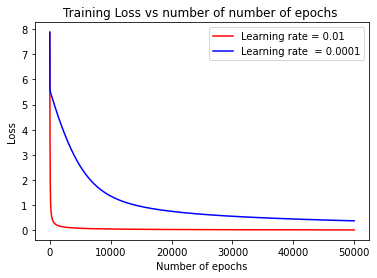

In [152]:
import matplotlib.pyplot as plt

# LOSSES
plt.plot(range(num_epochs), train_losses_lr001, color = 'red', label= 'Learning rate = 0.01')
plt.plot(range(num_epochs), train_losses_lr0001, color = 'blue', label= 'Learning rate  = 0.0001')
plt.title("Training Loss vs number of number of epochs ")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()